In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

In [10]:
# Convert the most recent date to a datetime object and calculate the date one year from the last date in the data set
most_recent_date_dlt = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d')
one_year_ago = most_recent_date_dlt - dt.timedelta(days=365)

# Design a query to retrieve the last 12 months of precipitation data and plot the results
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

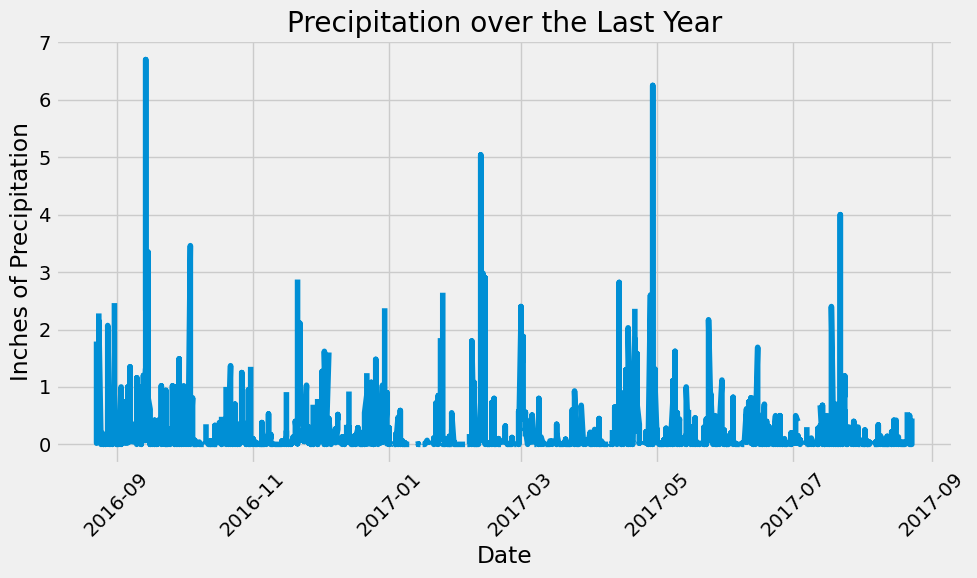

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = most_recent_date[0]
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago.strftime("%Y-%m-%d")).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
df['Date'] = pd.to_datetime(df['date'])
df.sort_values(by='Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['precipitation'])
plt.xlabel('Date')
plt.ylabel('Inches of Precipitation')
plt.title('Precipitation over the Last Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation,Date
count,2021.000000,2230
mean,0.177279,2017-02-16 05:31:15.874439424
min,0.000000,2016-08-23 00:00:00
25%,0.000000,2016-11-18 00:00:00
50%,0.020000,2017-02-14 12:00:00
75%,0.130000,2017-05-17 00:00:00
max,6.700000,2017-08-23 00:00:00
std,0.461190,NaN


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total stations in dataset: {total_stations}")

Total stations in dataset: 9


In [14]:
# Query to find the most active stations and their counts
active_stations = session.query(Measurement.station, func.count(Measurement.station).label("station_count"))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).all()

# List the stations and the counts in descending order
stations = [(station, count) for station, count in active_stations]
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Find the most active station ID
most_active_station = active_stations[0][0]

# Query to calculate min, max, and avg temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs).label("Min_Temp"),
    func.max(Measurement.tobs).label("Max_Temp"),
    func.avg(Measurement.tobs).label("Avg_Temp")
).filter(Measurement.station == most_active_station).all()

# Convert query results into a dictionary
temperature_summary = {
    "Station": most_active_station,
    "Min Temperature": temperature_stats[0][0],
    "Max Temperature": temperature_stats[0][1],
    "Avg Temperature": round(temperature_stats[0][2], 2)
}

temperature_summary

{'Station': 'USC00519281',
 'Min Temperature': 54.0,
 'Max Temperature': 85.0,
 'Avg Temperature': 71.66}

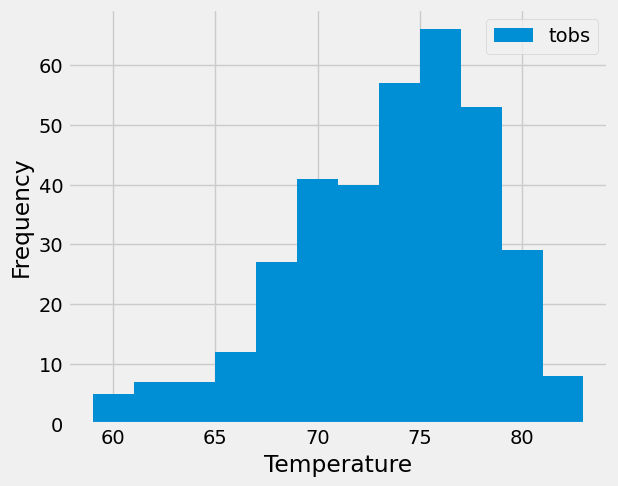

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).filter(Measurement.station=='USC00519281')\
    .filter(Measurement.date>='2016-08-23').all()

#Plot 
high_station_temp=pd.DataFrame(results,columns=['tobs'])
high_station_temp.plot.hist(bins=12)
plt.tight_layout()
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [17]:
# Close Session
session.close()